<a href="https://colab.research.google.com/github/jaberko/Dossier-de-test/blob/main/Exp1_Success_Rate_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries Importation**

In [186]:
import json
import numpy as np
from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import numpy as np

# **Loading Data**

In [187]:
# Load device data from JSON file
def load_devices(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

In [188]:
# Extract conflict pairs for conflicts matrix calculation and devices clustering.
def extract_conflicts_for_matrix(devices):
    conflicts = []
    for device in devices:
        did = device['device_id']
        for conflict in device.get('conflicts', []):
            a1 = conflict.get('action1')
            a2 = conflict.get('action2')
            conflicts.append((did, a1, a2))
    return conflicts

In [189]:
def extract_conflicts(devices):
    """
    For NCGT conflict resolution: returns list of (action1, action2, weight)
    """
    conflicts = set()
    for device in devices:
        for conflict in device.get('conflicts', []):
            a1 = conflict.get('action1')
            a2 = conflict.get('action2')
            weight = conflict.get('weight', 1.0)
            key = tuple(sorted([a1, a2])) + (weight,)
            conflicts.add(key)
    return list(conflicts)


In [190]:
# Generate conflict matrix
def generate_conflict_matrix(devices, conflicts):
    device_ids = [device['device_id'] for device in devices]
    n = len(device_ids)
    matrix = np.zeros((n, n), dtype=int)
    id_index = {did: idx for idx, did in enumerate(device_ids)}

    for d1, a1, a2 in conflicts:
        for d2 in device_ids:
            if d1 != d2:
                for device in devices:
                    if device['device_id'] == d2:
                        actions = [rule['Action'] for rule in device.get('ECARules', [])]
                        if a2 in actions:
                            i, j = id_index[d1], id_index[d2]
                            matrix[i, j] = 1
                            matrix[j, i] = 1
    return device_ids, matrix
# Display conflict matrix
def display_matrix(device_ids, matrix):
    print("\nConflict Matrix:")
    headers = ["Device"] + device_ids
    table = [[device_ids[i]] + list(row) for i, row in enumerate(matrix)]
    print(tabulate(table, headers, tablefmt="grid"))

# **KMeans Clustering**

In [191]:
def prepare_features(conflict_matrix, n_components=10):
    """
    Optional: reduce dimensionality of binary conflict matrix rows
    for better clustering with Euclidean-based KMeans.
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_features = svd.fit_transform(conflict_matrix)
    return reduced_features

def perform_kmeans_clustering(device_ids, conflict_matrix, n_clusters=4):
    # Step 1: optionally reduce dimension
    features = prepare_features(conflict_matrix, n_components=min(10, conflict_matrix.shape[1]))

    # Step 2: run KMeans on features
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)

    clusters = {}
    for idx, label in enumerate(labels):
        clusters.setdefault(label, []).append(device_ids[idx])
    return clusters

def display_clusters(clusters):
    print("\nDevice Clusters based on Conflict Similarity:")
    for label, devices in clusters.items():
        print(f"Cluster {label}: {', '.join(devices)}")

# **Voting Power Calculation**



In [192]:
# Step 6: Calculate voting power
def calculate_voting_power(device):
    alpha, beta, gamma = 0.4, 0.3, 0.3
    stake = device['stake']
    reliability = device['reliability']
    priority = device['priority']
    return round(alpha * stake + beta * reliability + gamma * priority, 3)

# Step 7: Display voting power matrix
def display_voting_power(devices):
    table = [[device['device_id'], device['stake'], device['reliability'], device['priority'], calculate_voting_power(device)] for device in devices]
    print("\nVoting Power Matrix:")
    print(tabulate(table, headers=["Device", "Stake", "Reliability", "Priority", "Voting Power"], tablefmt="grid"))

# **DPoS Delegation**

In [193]:
# Step 8: Select delegate from each cluster
def select_delegates(devices, clusters, print_result=True):
    device_map = {d['device_id']: d for d in devices}
    delegates = {}

    for cluster_id, device_ids in clusters.items():
        max_power = -1
        delegate_id = None
        for device_id in device_ids:
            device = device_map[device_id]
            vp = calculate_voting_power(device)
            if vp > max_power:
                max_power = vp
                delegate_id = device_id
        delegates[cluster_id] = delegate_id

    print("\nSelected Delegates:")
    for cid, did in delegates.items():
        print(f"Cluster {cid} → Delegate: {did}")

    return delegates  # ✅ Needed by conflict resolution


# **NCGT**

In [194]:
# Compute Best Actions for Each Device in a Cluster
def get_best_action_for_device(device):
    prefs = device.get("user_preferences", {})
    if not prefs:
        return None
    return max(prefs.items(), key=lambda x: x[1])[0]  # action with highest preference

In [195]:
# Build the Initial Strategy for All Clusters
def initialize_strategy(clusters, devices):
    device_map = {d["device_id"]: d for d in devices}
    strategy = {}

    for cluster_devices in clusters.values():
        for did in cluster_devices:
            best_action = get_best_action_for_device(device_map[did])
            if best_action:
                strategy[did] = best_action

    print("\n[Init] Initial Strategy (Best-preference actions per device):")
    for did, action in strategy.items():
        print(f"  {did}: {action}")
    return strategy


In [196]:
def calculate_cluster_utility(cluster_device_ids, strategy, other_actions, conflict_list, devices, lambda_weight=0.5, debug=False, cluster_id=None):
    device_map = {d["device_id"]: d for d in devices}
    utility = 0.0

    for device_id in cluster_device_ids:
        device = device_map[device_id]
        action = strategy.get(device_id)
        if not action:
            continue

        pref = device.get("user_preferences", {}).get(action, 0)
        penalty = 0

        # Check all global conflicts (bidirectional logic)
        for a1, a2, weight in conflict_list:
            if (action in (a1, a2)) and ((a1 if a2 == action else a2) in other_actions):
                penalty += weight

        partial_utility = pref - lambda_weight * penalty
        utility += partial_utility

        if debug:
            print(f"[Utility] Device {device_id} → Action: {action}")
            print(f"          Pref: {pref:.2f}, Penalty: {penalty:.2f}, Partial U: {partial_utility:.2f}")

    if debug:
        if cluster_id is not None:
            print(f"[Utility] Total Utility for Cluster {cluster_id}: {round(utility, 3)}\n")
        else:
            print(f"[Utility] Total Utility for Cluster: {round(utility, 3)}\n")

    return utility


In [197]:
from tabulate import tabulate

def print_cluster_utility_table(iteration_num, clusters, strategy, devices, conflict_list, lambda_weight=0.5):
    print(f"\n[NCGT] ▶ Iteration {iteration_num}")

    device_map = {d['device_id']: d for d in devices}
    full_table = []

    for cid, device_ids in clusters.items():
        cluster_total = 0.0

        for did in device_ids:
            device = device_map[did]
            action = strategy.get(did)
            pref = device.get("user_preferences", {}).get(action, 0)

            # ✅ Compare against all other device actions, not just other clusters
            other_actions = [
                strategy[odid]
                for odid in strategy if odid != did
            ]

            # Compute penalty from global conflict list
            penalty = 0.0
            for a1, a2, weight in conflict_list:
                if (action in (a1, a2)) and ((a1 if a2 == action else a2) in other_actions):
                    penalty += weight

            partial_utility = pref - lambda_weight * penalty
            cluster_total += partial_utility

            full_table.append([
                cid, did, action, f"{pref:.2f}", f"{penalty:.2f}", f"{partial_utility:.2f}"
            ])

        # Add row showing cluster utility
        full_table.append([cid, "Cluster Utility", "", "", "", f"{cluster_total:.3f}"])

    headers = ["Cluster", "Device", "Action", "Pref", "Penalty", "Partial U"]
    print(tabulate(full_table, headers=headers, tablefmt="grid"))


In [198]:
def print_iteration_summary(iteration_num, logs):
    if not logs:
        return

    print(f"\n[Summary] Cluster Updates in Iteration {iteration_num}")

    table = []
    for log in logs:
        cid = log['cluster_id']
        before = log['before_utility']
        after = log['after_utility']
        for did, old_action, new_action in log['changes']:
            table.append([cid, did, old_action, new_action, f"{before:.3f} → {after:.3f}"])

    headers = ["Cluster", "Device", "Old Action", "New Action", "Utility"]
    print(tabulate(table, headers=headers, tablefmt="grid"))

In [199]:
# Resolve Conflicts via NCGT (Asynchronous Loop)
from itertools import product

def resolve_conflicts_with_ncgt(devices, clusters, delegates, conflict_list, lambda_weight=0.5):
    device_map = {d["device_id"]: d for d in devices}

    # Step 1: Initialize best-preference action per device
    strategy = {}
    for device in devices:
        prefs = device.get("user_preferences", {})
        if prefs:
            best_action = max(prefs.items(), key=lambda x: x[1])[0]
            strategy[device["device_id"]] = best_action

    changed = True
    iteration = 0

    while changed:
        changed = False
        iteration_log = []

        # 🔹 Print per-device utility and cluster totals
        print_cluster_utility_table(iteration + 1, clusters, strategy, devices, conflict_list, lambda_weight)

        for cid, cluster_device_ids in clusters.items():
            cluster_changes = []

            # Current utility
            initial_utility = calculate_cluster_utility(
                cluster_device_ids, strategy,
                [strategy[did] for ocid, dids in clusters.items() if ocid != cid for did in dids if did in strategy],
                conflict_list, devices, lambda_weight, debug=False, cluster_id=cid
            )

            # Generate all possible combinations of this cluster's device actions
            action_space = []
            for did in cluster_device_ids:
                dev = device_map[did]
                actions = list(dev.get("user_preferences", {}).keys())
                action_space.append(actions)

            best_strategy = {did: strategy[did] for did in cluster_device_ids}
            best_utility = initial_utility

            for combo in product(*action_space):
                temp_strategy = strategy.copy()
                for idx, did in enumerate(cluster_device_ids):
                    temp_strategy[did] = combo[idx]

                temp_utility = calculate_cluster_utility(
                    cluster_device_ids, temp_strategy,
                    [temp_strategy[did] for ocid, dids in clusters.items() if ocid != cid for did in dids if did in temp_strategy],
                    conflict_list, devices, lambda_weight, debug=False, cluster_id=cid
                )

                if temp_utility > best_utility:
                    cluster_changes = []
                    for idx, did in enumerate(cluster_device_ids):
                        old_action = strategy[did]
                        new_action = combo[idx]
                        if old_action != new_action:
                            cluster_changes.append((did, old_action, new_action))
                            strategy[did] = new_action
                    best_utility = temp_utility
                    changed = True

                    if cluster_changes:
                        iteration_log.append({
                            "cluster_id": cid,
                            "before_utility": round(initial_utility, 3),
                            "after_utility": round(best_utility, 3),
                            "changes": cluster_changes
                        })

        # 🔹 Print summary of action changes
        print_iteration_summary(iteration + 1, iteration_log)
        iteration += 1

    return strategy, iteration



# **Experiments**

# **Success Rate**



In [200]:
def count_active_conflicts(strategy, conflict_list):
    active_conflicts = 0
    for a1, a2, _ in conflict_list:
        selected_actions = set(strategy.values())
        if a1 in selected_actions and a2 in selected_actions:
            active_conflicts += 1
    return active_conflicts


In [201]:
def compute_success_rate(strategy, conflict_list):
    total_conflicts = len(conflict_list)
    unresolved = count_active_conflicts(strategy, conflict_list)
    resolved = total_conflicts - unresolved
    success_rate = resolved / total_conflicts if total_conflicts > 0 else 1.0
    return {
        "total": total_conflicts,
        "resolved": resolved,
        "unresolved": unresolved,
        "success_rate": round(success_rate * 100, 2)
    }

In [202]:
def compute_total_utility(strategy, clusters, devices, conflict_list, lambda_weight=1.0):
    total_utility = 0.0
    for cid, device_ids in clusters.items():
        other_actions = [strategy[did] for ocid, dids in clusters.items() if ocid != cid for did in dids]
        utility = calculate_cluster_utility(
            device_ids, strategy, other_actions, conflict_list, devices, lambda_weight
        )
        total_utility += utility
    return round(total_utility, 3)


In [203]:
from re import S
from tabulate import tabulate

def compare_resolution_methods(devices, clusters, delegates, conflict_list, lambda_weight=1.0):
    print("\n▶ Running DPoS-NCGT...")
    strategy_dpos, iters_dpos = resolve_conflicts_with_ncgt(devices, clusters, delegates, conflict_list, lambda_weight)
    metrics_dpos = compute_success_rate(strategy_dpos, conflict_list)
    metrics_dpos["iterations"] = iters_dpos


    print("\n▶ Running Plain NCGT (no clustering)...")
    # ✅ Each device is its own singleton cluster
    singleton_clusters = {
        idx: [device['device_id']] for idx, device in enumerate(devices)
    }
    dummy_delegates = {
        idx: device['device_id'] for idx, device in enumerate(devices)
    }

    strategy_ncgt, iters_ncgt = resolve_conflicts_with_ncgt(devices, singleton_clusters, dummy_delegates, conflict_list, lambda_weight)
    metrics_ncgt = compute_success_rate(strategy_ncgt, conflict_list)
    metrics_ncgt["iterations"] = iters_ncgt

    # 📊 Print comparison table
    print("\n✅ Conflict Resolution Comparison (Success Rate):")
    print(tabulate([
        ["DPoS-NCGT", metrics_dpos["total"], metrics_dpos["resolved"], metrics_dpos["unresolved"], f"{metrics_dpos['success_rate']}%", metrics_dpos["iterations"]],
        ["Plain NCGT", metrics_ncgt["total"], metrics_ncgt["resolved"], metrics_ncgt["unresolved"], f"{metrics_ncgt['success_rate']}%",  metrics_ncgt["iterations"]]
    ], headers=["Approach", "Total Conflicts", "Resolved", "Unresolved", "Success Rate", "Iterations"], tablefmt="grid"))

    return {
        "DPoS-NCGT": {"strategy": strategy_dpos, **metrics_dpos},
        "NCGT": {"strategy": strategy_ncgt, **metrics_ncgt}
    }


# **Visualization**

In [204]:
import json
from tabulate import tabulate

def compare_resolution_methods(devices, clusters, delegates, conflict_list, lambda_weight=1.0):
    # DPoS-NCGT
    strategy_dpos, iters_dpos = resolve_conflicts_with_ncgt(devices, clusters, delegates, conflict_list, lambda_weight)
    metrics_dpos = compute_success_rate(strategy_dpos, conflict_list)
    metrics_dpos["iterations"] = iters_dpos

    # Plain NCGT — one cluster per device
    singleton_clusters = {i: [d["device_id"]] for i, d in enumerate(devices)}
    singleton_delegates = {i: d["device_id"] for i, d in enumerate(devices)}
    strategy_ncgt, iters_ncgt = resolve_conflicts_with_ncgt(devices, singleton_clusters, singleton_delegates, conflict_list, lambda_weight)
    metrics_ncgt = compute_success_rate(strategy_ncgt, conflict_list)
    metrics_ncgt["iterations"] = iters_ncgt

    metrics_dpos["utility"] = compute_total_utility(strategy_dpos, clusters, devices, conflict_list, lambda_weight)
    metrics_ncgt["utility"] = compute_total_utility(strategy_ncgt, singleton_clusters, devices, conflict_list, lambda_weight)


    return metrics_dpos, metrics_ncgt

In [205]:
def run_batch_experiment(DATASETS, k):
    all_results = []

    for file, label in DATASETS:
        print(f"\n📂 Evaluating dataset: {label} ({file})")

        # Load devices
        devices = load_devices(file)
        conflict_list = extract_conflicts(devices)
        conflict_matrix_input = extract_conflicts_for_matrix(devices)

        # Clustering for DPoS
        device_ids, matrix = generate_conflict_matrix(devices, conflict_matrix_input)
        clusters = perform_kmeans_clustering(device_ids, matrix, n_clusters=k)
        delegates = select_delegates(devices, clusters)

        # Run comparison
        metrics_dpos, metrics_ncgt = compare_resolution_methods(devices, clusters, delegates, conflict_list)

        # Collect result row for both methods
        all_results.append(["DPoS-NCGT", label, metrics_dpos["total"], metrics_dpos["resolved"],
                    metrics_dpos["unresolved"], f"{metrics_dpos['success_rate']}%", metrics_dpos["iterations"], metrics_dpos["utility"]])
        all_results.append(["Plain NCGT", label, metrics_ncgt["total"], metrics_ncgt["resolved"],
                    metrics_ncgt["unresolved"], f"{metrics_ncgt['success_rate']}%", metrics_ncgt["iterations"], metrics_ncgt["utility"]])

    # Print final comparison table
    print("\n📊 Batch Conflict Resolution Results:\n")
    print(tabulate(
        all_results,
        headers=["Approach", "Dataset", "Total Conflicts", "Resolved", "Unresolved", "Success Rate", "Iterations", "Utility"],
        tablefmt="grid"
    ))

    plot_all_summary_charts(all_results)


In [206]:
import matplotlib.pyplot as plt

def plot_all_summary_charts(batch_results):
    # Extract x-axis values and setup
    datasets = sorted({r[1] for r in batch_results}, key=lambda x: int(x.strip('%')))
    x = [int(d.strip('%')) for d in datasets]
    x_pos = range(len(datasets))
    methods = ["DPoS-NCGT", "Plain NCGT"]

    # Containers
    dpos_rates, plain_rates = [], []
    dpos_iters, plain_iters = [], []
    dpos_utils, plain_utils = [], []
    resolved = {m: [] for m in methods}
    unresolved = {m: [] for m in methods}

    # Fill data
    for d in datasets:
        for row in batch_results:
            if row[1] == d:
                if row[0] == "DPoS-NCGT":
                    dpos_rates.append(float(row[5].strip('%')))
                    dpos_iters.append(row[6])
                    dpos_utils.append(row[7])
                    resolved["DPoS-NCGT"].append(row[3])
                    unresolved["DPoS-NCGT"].append(row[4])
                elif row[0] == "Plain NCGT":
                    plain_rates.append(float(row[5].strip('%')))
                    plain_iters.append(row[6])
                    plain_utils.append(row[7])
                    resolved["Plain NCGT"].append(row[3])
                    unresolved["Plain NCGT"].append(row[4])

    # Setup 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("DPoS-NCGT vs Plain NCGT: Conflict Resolution Summary", fontsize=16)

    # ─── 1. Success Rate ──────────────────────
    ax = axes[0][0]
    ax.plot(x, dpos_rates, marker='o', label='DPoS-NCGT', linewidth=2)
    ax.plot(x, plain_rates, marker='s', label='Plain NCGT', linewidth=2)
    ax.set_title("Success Rate vs Conflict Density")
    ax.set_xlabel("Conflict Density (%)")
    ax.set_ylabel("Success Rate (%)")
    ax.set_xticks(x)
    ax.set_yticks(range(0, 110, 10))
    ax.grid(True)
    ax.legend()

    # ─── 2. Resolved vs Unresolved ────────────
    ax = axes[0][1]
    bar_width = 0.35
    ax.bar(x_pos, resolved["DPoS-NCGT"], width=bar_width, color='green', label='DPoS-NCGT Resolved')
    ax.bar(x_pos, unresolved["DPoS-NCGT"], width=bar_width, bottom=resolved["DPoS-NCGT"], color='red', label='DPoS-NCGT Unresolved')

    x2 = [i + bar_width for i in x_pos]
    ax.bar(x2, resolved["Plain NCGT"], width=bar_width, color='lightgreen', label='Plain NCGT Resolved')
    ax.bar(x2, unresolved["Plain NCGT"], width=bar_width, bottom=resolved["Plain NCGT"], color='salmon', label='Plain NCGT Unresolved')
    ax.set_title("Resolved vs Unresolved Conflicts")
    ax.set_xlabel("Conflict Density (%)")
    ax.set_ylabel("Number of Conflicts")
    ax.set_xticks([i + bar_width / 2 for i in x_pos])
    ax.set_xticklabels(datasets)
    ax.legend()

    # ─── 3. Iterations ────────────────────────
    ax = axes[1][0]
    ax.plot(x, dpos_iters, marker='o', label='DPoS-NCGT', linewidth=2)
    ax.plot(x, plain_iters, marker='s', label='Plain NCGT', linewidth=2)
    ax.set_title("Iterations vs Conflict Density")
    ax.set_xlabel("Conflict Density (%)")
    ax.set_ylabel("Iterations")
    ax.set_xticks(x)
    ax.grid(True)
    ax.legend()

    # ─── 4. Total Utility ─────────────────────
    ax = axes[1][1]
    ax.plot(x, dpos_utils, marker='o', label='DPoS-NCGT', linewidth=2)
    ax.plot(x, plain_utils, marker='s', label='Plain NCGT', linewidth=2)
    ax.set_title("Total Utility vs Conflict Density")
    ax.set_xlabel("Conflict Density (%)")
    ax.set_ylabel("Total Utility")
    ax.set_xticks(x)
    ax.grid(True)
    ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
    plt.show()


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
|         7 | D008     | dim_light        | turn_off_light    | -0.540 → -0.410 |
+-----------+----------+------------------+-------------------+-----------------+
|        10 | D011     | lock_door        | unlock_door       | -2.840 → -2.480 |
+-----------+----------+------------------+-------------------+-----------------+
|        12 | D013     | enter_standby    | adjust_brightness | -2.970 → -2.000 |
+-----------+----------+------------------+-------------------+-----------------+
|        16 | D017     | report_occupancy | report_vacancy    | -4.480 → -3.640 |
+-----------+----------+------------------+-------------------+-----------------+

[NCGT] ▶ Iteration 4
+-----------+-----------------+---------------------+--------+-----------+-------------+
|   Cluster | Device          | Action              | Pref   | Penalty   |   Partial U |
+===========+=================+=====================+========+====

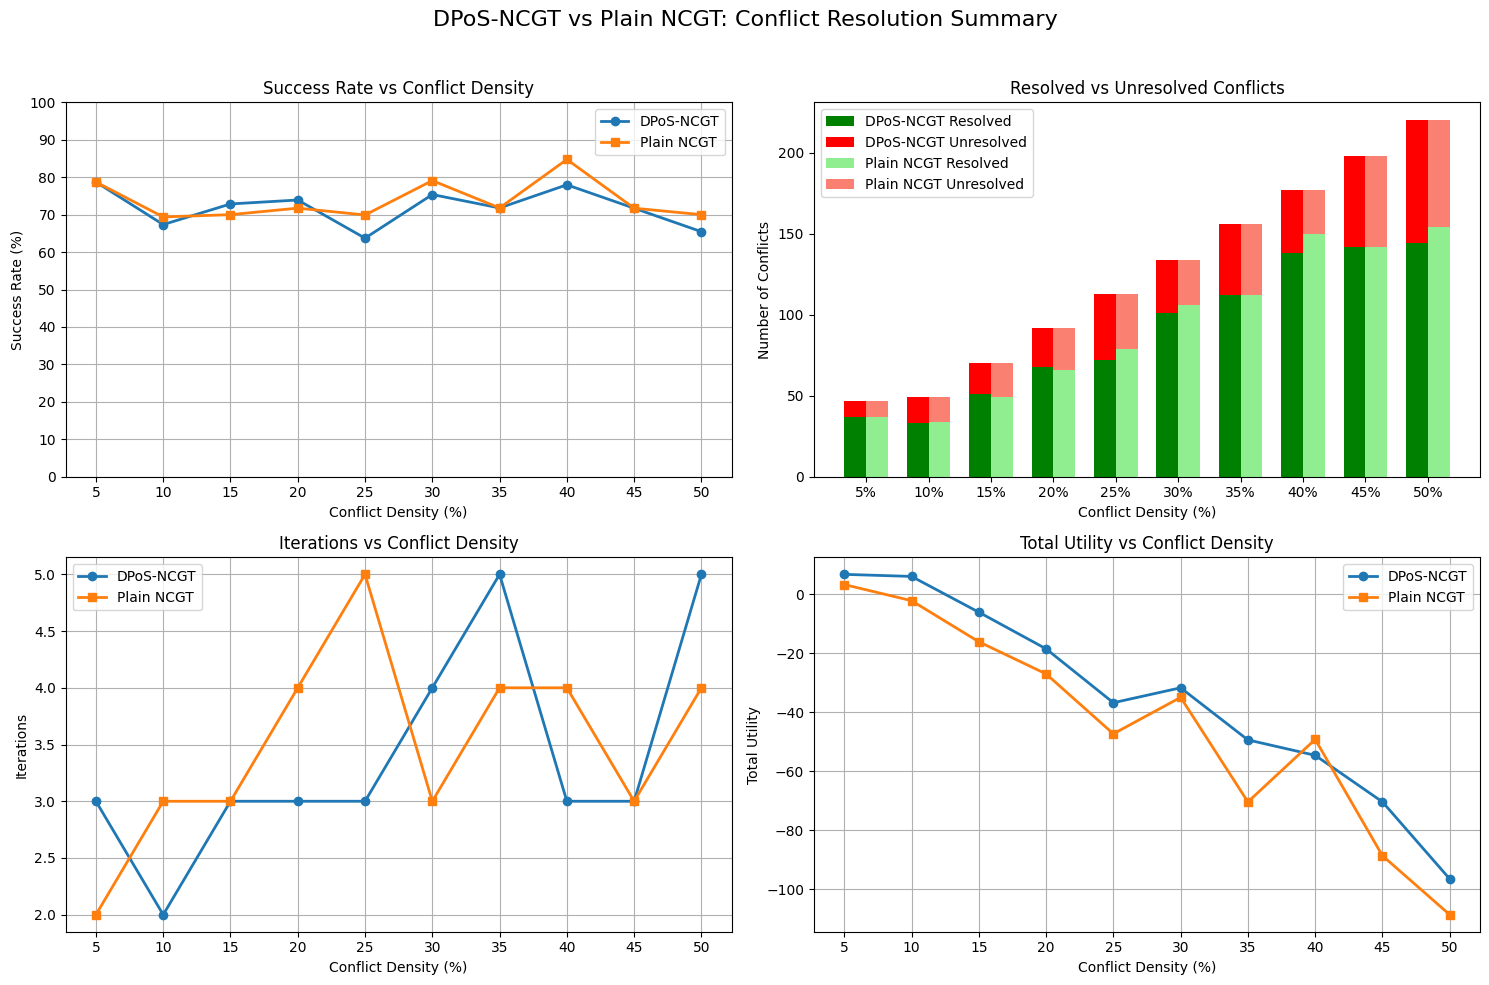

In [208]:
# Run it
if __name__ == "__main__":

    # Datasets to evaluate
    DATASETS = [
        ("devices_30_CR_5.json", "5%"),
        ("devices_30_CR_10.json", "10%"),
        ("devices_30_CR_15.json", "15%"),
        ("devices_30_CR_20.json", "20%"),
        ("devices_30_CR_25.json", "25%"),
        ("devices_30_CR_30.json", "30%"),
        ("devices_30_CR_35.json", "35%"),
        ("devices_30_CR_40.json", "40%"),
        ("devices_30_CR_45.json", "45%"),
        ("devices_30_CR_50.json", "50%")
    ]

    n_clusters = 5
    run_batch_experiment(DATASETS, n_clusters)